<a href="https://colab.research.google.com/github/deviljerry/-Building-a-Simple-CNN-for-Image-Classification-Using-PyTorch-SVHN-Dataset-/blob/main/CNNforImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for Image Classification
##1. Use Tiny ImageNet or SVHN (Google Street View house) dataset.
##2. Build a simple CNN from scratch using PyTorch or Keras:
 2 convolutional layers (ReLU activation)
 1 max pooling layer
 1 fully connected output layer
##3. Train for at least 10 epochs and plot:
 Training loss vs epochs
 Training and validation accuracy curves
##4. Report final accuracy and confusion matrix.

In [4]:
# ===============================
#  CNN for Image Classification (SVHN)
# ===============================

# 📦 Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np



In [2]:
# ✅ Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("✅ Using device:", device)


✅ Using device: cuda


In [3]:
# ===============================
# Step 1 - Load SVHN Dataset
# ===============================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print(f"✅ Training samples: {len(trainset)}, Testing samples: {len(testset)}")


100%|██████████| 182M/182M [00:21<00:00, 8.49MB/s]
100%|██████████| 64.3M/64.3M [00:15<00:00, 4.18MB/s]


✅ Training samples: 73257, Testing samples: 26032


In [5]:
# ===============================
# Step 2 - Define Simple CNN Model
# ===============================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # Padding=1 keeps same HxW
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # halves spatial size
        self.fc1 = nn.Linear(64 * 16 * 16, 10)  # SVHN has 10 digit classes (0-9)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16)
        x = self.fc1(x)
        return x

model = SimpleCNN().to(device)

In [6]:
# ===============================
# Step 3 - Loss and Optimizer
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
# ===============================
# Step 4 - Train the Model
# ===============================
num_epochs = 10
train_loss, train_acc, val_acc = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(trainloader))
    train_acc.append(100 * correct / total)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss[-1]:.4f}, "
          f"Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%")


Epoch [1/10] - Loss: 0.9063, Train Acc: 71.79%, Val Acc: 79.26%
Epoch [2/10] - Loss: 0.5549, Train Acc: 84.02%, Val Acc: 81.23%
Epoch [3/10] - Loss: 0.5046, Train Acc: 85.39%, Val Acc: 82.90%
Epoch [4/10] - Loss: 0.4686, Train Acc: 86.37%, Val Acc: 82.52%
Epoch [5/10] - Loss: 0.4398, Train Acc: 87.39%, Val Acc: 83.53%
Epoch [6/10] - Loss: 0.4211, Train Acc: 87.73%, Val Acc: 83.70%
Epoch [7/10] - Loss: 0.4006, Train Acc: 88.38%, Val Acc: 83.43%
Epoch [8/10] - Loss: 0.3858, Train Acc: 88.81%, Val Acc: 84.00%
Epoch [9/10] - Loss: 0.3691, Train Acc: 89.24%, Val Acc: 83.59%
Epoch [10/10] - Loss: 0.3543, Train Acc: 89.62%, Val Acc: 83.76%


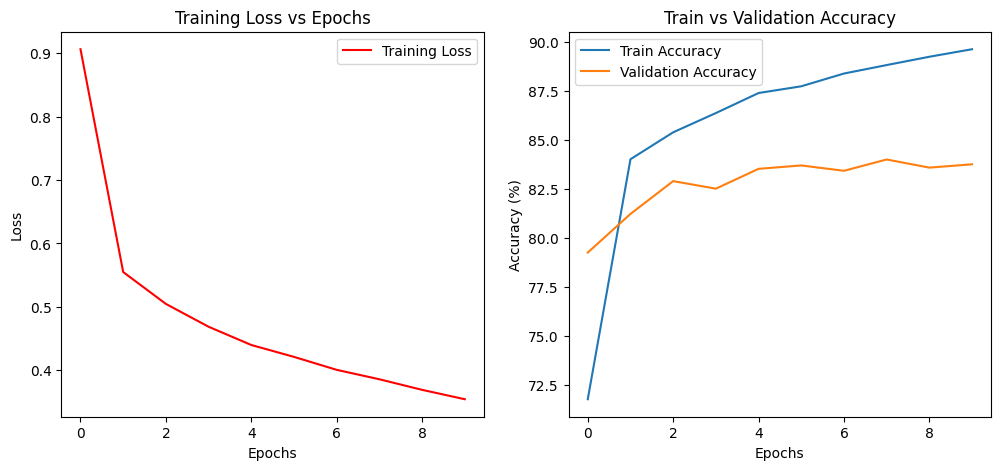

In [8]:
# ===============================
# Step 5 - Plot Loss & Accuracy
# ===============================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Training Loss', color='red')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.title('Training Loss vs Epochs')

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.title('Train vs Validation Accuracy')
plt.show()


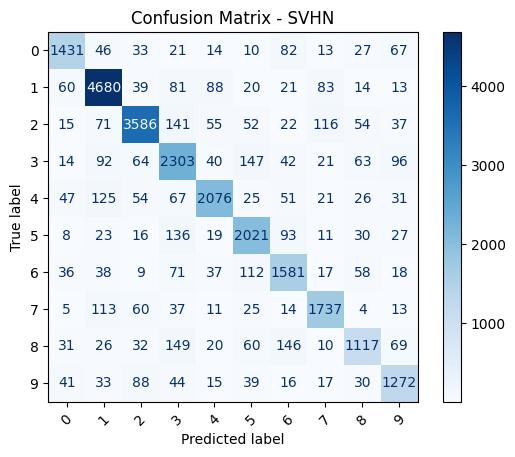

In [9]:
# ===============================
# Step 6 - Confusion Matrix
# ===============================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - SVHN")
plt.show()

In [10]:
# ===============================
# Step 7 - Discussion
# ===============================
print("""
📘 Discussion:
- Padding = 1 keeps the feature map size same after convolution (so 32x32 → 32x32).
- Stride = 1 ensures detailed feature extraction.
- After applying MaxPooling (2x2), each spatial dimension is halved (32x32 → 16x16).
- This reduces computation and helps the network focus on higher-level patterns.
""")



📘 Discussion:
- Padding = 1 keeps the feature map size same after convolution (so 32x32 → 32x32).
- Stride = 1 ensures detailed feature extraction.
- After applying MaxPooling (2x2), each spatial dimension is halved (32x32 → 16x16).
- This reduces computation and helps the network focus on higher-level patterns.

